In [ ]:
import numpy as np 
from sklearn.model_selection import train_test_split

import tensorflow as tf 
from tensorflow.keras import datasets, layers, models, optimizers, losses, metrics 

# データの準備
mnist = datasets.mnist 
(x_train_val, t_train_val), (x_test, t_test) = mnist.load_data() 
x_train, x_val, t_train, t_val = train_test_split(x_train_val, t_train_val, test_size=0.3, random_state=0)

In [ ]:
x_train = x_train[..., tf.newaxis] / 255.0
x_val = x_val[..., tf.newaxis] / 255.0
x_test = x_test[..., tf.newaxis] / 255.0

In [ ]:
# Augmentation
def augment(image, label):
  # img = tf.image.rot90(image)
  img = tf.image.random_flip_left_right(image)
  img = tf.image.random_flip_up_down(img)
  return (img, label)

In [ ]:
batch_size = 256

# train_ds = tf.data.Dataset.from_tensor_slices((x_train, t_train)).map(augment).shuffle(1000).batch(batch_size)
train_ds = tf.data.Dataset.from_tensor_slices((x_train, t_train)).shuffle(1000).batch(batch_size)
val_ds = tf.data.Dataset.from_tensor_slices((x_val, t_val)).batch(batch_size)
test_ds = tf.data.Dataset.from_tensor_slices((x_test, t_test)).batch(batch_size)

In [ ]:
# カスタム活性化関数
def swish(x, beta=1):
    return x * tf.nn.sigmoid(beta * x)

# Early Stopping
class EarlyStopping:
    def __init__(self, patience=0, verbose=0):
        self._step = 0 
        self._loss = float('inf')
        self.patience = patience 
        self.verbose = verbose 
    def __call__(self, loss):
        if self._loss < loss:
            self._step += 1 
            if self._step > self.patience:
                if self.verbose:
                    print("early stopping")
                return True 
        else:
            self._step = 0
            self._loss = loss
        return False

In [ ]:
# モデル
class Net(models.Model):
    def __init__(self, hidden_dim, output_dim):
        super().__init__() 
        self.model = models.Sequential([
            layers.BatchNormalization(),
            layers.Conv2D(hidden_dim, kernel_size=3, activation=swish, kernel_initializer='he_normal'), 
            layers.Flatten(),
            layers.Dropout(0.5),
            layers.Dense(output_dim, activation="softmax")
        ])
    def call(self, x):
        return self.model(x)

net = Net(64, 10)
es = EarlyStopping()

In [ ]:
criterion = losses.SparseCategoricalCrossentropy()
optimizer = optimizers.Adam()
train_loss = metrics.Mean()
train_acc = metrics.SparseCategoricalAccuracy() 
val_loss = metrics.Mean()
val_acc = metrics.SparseCategoricalAccuracy() 

In [ ]:
@tf.function
def train(x, t):
    # 勾配算出するスコープを指定
    with tf.GradientTape() as tape:
        preds = net(x)
        loss = criterion(t, preds)
        grads = tape.gradient(loss, net.trainable_variables) # 逆伝播
    # 更新
    optimizer.apply_gradients(zip(grads, net.trainable_variables))
    train_loss(loss)
    train_acc(t, preds)
    return loss 

def test(x, t):
    preds = net(x)
    loss = criterion(t, preds)
    val_loss(loss)
    val_acc(t, preds)

In [ ]:
epochs = 50
batch_size=256
history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

In [ ]:
#from tqdm import tqdm

# 学習
for epoch in range(epochs):
    for batch in train_ds:
        x, t = batch
        train(x, t)
    for batch in val_ds:
        x, t = batch
        test(x, t)

    #　ログ
    history['train_loss'].append(train_loss.result().numpy())
    history['train_acc'].append(train_acc.result().numpy())
    history['val_loss'].append(val_loss.result().numpy())
    history['val_acc'].append(val_acc.result().numpy())

    template = 'Epoch {}, Loss: {}, Accuracy: {}, Validation Loss: {}, Validation Accuracy: {}'
    print (template.format(epoch+1,
                         train_loss.result(),
                         train_acc.result()*100,
                         val_loss.result(),
                         val_acc.result()*100))

    train_loss.reset_states()
    train_acc.reset_states()
    val_loss.reset_states()
    val_acc.reset_states()

    # Early Stopping
    #if es(val_loss): 
    #    break


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Epoch 1, Loss: 0.3190842270851135, Accuracy: 90.47856903076172, Validation Loss: 0.17704255878925323, Validation Accuracy: 95.13333129882812
Epoch 2, Loss: 0.12972302734851837, Accuracy: 96.31190490722656, Validation Loss: 0.12080865353345871, Validation Accuracy: 96.81111145019531
Epoch 3, Loss: 0.07674852758646011, Accuracy: 97.7642822265625, Validation Loss: 0.10612086951732635, Validation Accuracy: 96.97222137451172
Epoch 4, Loss: 0.05116790905594826, Accuracy: 98.51667022705078, Validation Loss: 0.

In [ ]:
import pandas as pd 
import matplotlib.pyplot as plt

def results_plot(history):
    plt.style.use('ggplot')
    results = pd.DataFrame(history)
    results[['train_loss', 'val_loss']].plot()
    results[['train_acc', 'val_acc']].plot()
    return results

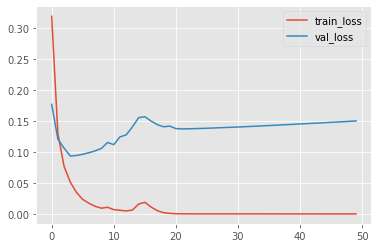

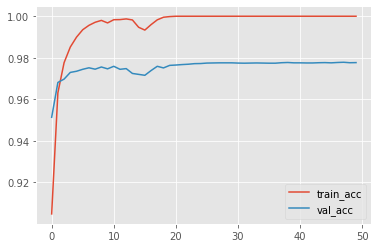

In [ ]:
results = results_plot(history)

## CIFAR 10 で @tf.function の検証

In [ ]:
import numpy as np 

import tensorflow as tf 
from tensorflow.keras import datasets, layers, models, optimizers, losses, metrics 
import tensorflow_datasets as tfds

datasets = tfds.load("food101", as_supervised=True)
train, test = datasets['train'], datasets['validation']

def scale(image, label):
    image = tf.cast(image, tf.float32)
    image /= 255.0
    image = tf.image.resize(image, [224, 224])
    return image, label

batch_size = 32

train_ds = train.map(scale).shuffle(10000, seed=0).batch(batch_size)
test_ds = test.map(scale).batch(batch_size)

In [ ]:
import tensorflow_hub as hub

# モデル
class Net(models.Model):
    def __init__(self, output_dim=101):
        super().__init__() 
        self.model = models.Sequential([
            hub.KerasLayer(
                "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/2",
                input_shape=(224, 224, 3),
                trainable=True
                ),
            layers.Dense(output_dim, activation="softmax")
        ])
    def call(self, x):
        return self.model(x)

net = Net()

In [ ]:
criterion = losses.SparseCategoricalCrossentropy()
optimizer = optimizers.SGD(learning_rate=1e-3, momentum=0.9, nesterov=True)
train_loss = metrics.Mean()
train_acc = metrics.SparseCategoricalAccuracy() 
test_loss = metrics.Mean()
test_acc = metrics.SparseCategoricalAccuracy() 

In [ ]:
epochs = 1
history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

In [ ]:
def train(x, t):
    with tf.GradientTape() as tape:
        preds = net(x)
        loss = criterion(t, preds)
        grads = tape.gradient(loss, net.trainable_variables) 
    optimizer.apply_gradients(zip(grads, net.trainable_variables))
    train_loss(loss)
    train_acc(t, preds)

def test(x, t):
    preds = net(x)
    loss = criterion(t, preds)
    test_loss(loss)
    test_acc(t, preds)

In [ ]:
import time

start = time.time()
print('start {}'.format(start))

for epoch in range(epochs):
    for batch in train_ds:
        x, t = batch
        train(x, t)
    for batch in test_ds:
        x, t = batch
        test(x, t)

    train_loss.reset_states()
    train_acc.reset_states()
    test_loss.reset_states()
    test_acc.reset_states()

end = time.time()
print('end {}'.format(end))

print("@tf.function なし：{}".format(end - start))

start 1599118735.4095879
end 1599119590.4397452
@tf.function なし：855.030157327652


In [ ]:
@tf.function
def train(x, t):
    with tf.GradientTape() as tape:
        preds = net(x)
        loss = criterion(t, preds)
        grads = tape.gradient(loss, net.trainable_variables) 
    optimizer.apply_gradients(zip(grads, net.trainable_variables))
    train_loss(loss)
    train_acc(t, preds)
    return loss 

def test(x, t):
    preds = net(x)
    loss = criterion(t, preds)
    test_loss(loss)
    test_acc(t, preds)

start = time.time()
print('start {}'.format(start))

for epoch in range(epochs):
    for batch in train_ds:
        x, t = batch
        train(x, t)
    for batch in test_ds:
        x, t = batch
        test(x, t)

    train_loss.reset_states()
    train_acc.reset_states()
    test_loss.reset_states()
    test_acc.reset_states()

end = time.time()
print('end {}'.format(end))

print("@tf.function あり：{}".format(end - start))

start 1599119591.4841387
end 1599120187.5748258
@tf.function あり：596.0906870365143
